In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import tensorflow_hub as thub
import tensorflow.keras.backend as K

from lib.data_utils import *

from art.classifiers import KerasClassifier
from art.attacks import FastGradientMethod
import art

In [2]:
import pandas
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [3]:
def sample_by_class(data, labels, num_samples=100):
    sample_data = []
    sample_labels = []
    unq_labels = list(range(labels.shape[1]))
    for label in unq_labels:
        idx = labels[:,label]==1
        sample_set = data[idx][0:num_samples].copy()
        label_set = labels[idx][0:num_samples].copy()
        sample_data.append(sample_set)
        sample_labels.append(label_set)
    
    sample_data = np.concatenate(sample_data)
    sample_labels = np.concatenate(sample_labels)
    print(sample_data.shape, sample_labels.shape)
    return sample_data, sample_labels

def subset_data(data, labels, fraction=5):
    data_size = data.shape[0]
    out_size = int(data_size*fraction/100)
    idx = np.random.choice(data_size, out_size, replace=False)
    out_data = data[idx].copy()
    out_labels = labels[idx].copy()
    
    print(out_data.shape, out_labels.shape)
    return out_data, out_labels

In [4]:
# Load the raw CIFAR-10 data
cifar10_dir = 'lib/datasets/cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10(cifar10_dir)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [5]:
testd = x_train[0:1000].copy()
testl = y_train[0:1000].copy()

In [6]:
def build_ganeval_model():
    K.clear_session()
    model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
    ganeval_module = thub.Module(model_url)
    
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
    model.add(thub.KerasLayer(ganeval_module))
    model.add(tf.keras.layers.Activation('softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=1e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [7]:
ge_cifar_clf = build_ganeval_model()
ge_cifar_clf.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 10)                7796426   
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [10]:
# Another ge_cifar model with more layers

K.clear_session()
#model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"

ganeval_module_new = thub.Module(model_url)
# gan_eval_layer = thub.KerasLayer(model_url)


ge_cifar_new_clf = tf.keras.Sequential()
ge_cifar_new_clf.add(tf.keras.layers.InputLayer(input_shape=(32,32,3)))
ge_cifar_new_clf.add(thub.KerasLayer(ganeval_module_new))
ge_cifar_new_clf.add(tf.keras.layers.Activation('softmax'))
ge_cifar_new_clf.add(tf.keras.layers.Activation('relu'))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [11]:
ge_cifar_new_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 10)                7796426   
_________________________________________________________________
activation (Activation)      (None, 10)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________


In [12]:
ge_cifar_new_clf.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=1e-4),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

In [13]:
ge_cifar_new_clf.evaluate(testd, testl)

1000/1000 [==============================] - 3s 3ms/sample - loss: 0.0017 - acc: 1.0000


[0.00166802722774446, 1.0]

# Testing the retrieved hub model by evaluating on train data
Should give us 100% or something close to that

In [ ]:
ge_cifar_clf.evaluate(testd, testl)

# Testing a sample attack

In [ ]:
from art.attacks import FastGradientMethod

classifier = KerasClassifier(model=ge_cifar_clf, clip_values=(0, 1), use_logits=False)
attack_fgsm = FastGradientMethod(classifier=classifier, eps=0.4)

In [13]:
x_test_adv = attack_fgsm.generate(testd.copy())

In [14]:
ge_cifar_clf.evaluate(x_test_adv, testl)

1000/1000 [==============================] - 3s 3ms/sample - loss: 6.9334 - acc: 0.1020


[6.933382461547851, 0.102]

# Define the substitute classifier for our model

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [9]:
def build_substitute_model():
    model = tf.keras.Sequential( )
    model.add( Conv2D( 32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32,32,3) ) )
    model.add( Conv2D( 64, (3, 3), padding='same', activation='relu' ) )
    model.add( MaxPooling2D( pool_size=(2, 2) ) )
    model.add( Flatten( ) )
    model.add( Dense( 128, activation='relu' ) )
    model.add( Dense(10, activation='softmax' ) )
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer='adam',
                  metrics=[ 'accuracy' ] )
    
    return model

In [10]:
sub_clf = build_substitute_model()

sub_clf.summary( )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2097280   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 2,117,962
Trainable params: 2,117,962
Non-trainable params: 0
____________________________________________

In [11]:
x_train_adv, y_train_adv = sample_by_class(x_train, y_train, num_samples=100)
x_test_adv, y_test_adv = sample_by_class(x_test, y_test, num_samples=100)

(1000, 32, 32, 3) (1000, 10)
(1000, 32, 32, 3) (1000, 10)


In [12]:
partial_x_train, partial_y_train = subset_data(x_train, y_train, fraction=15)

(7500, 32, 32, 3) (7500, 10)


# Attacks

In [13]:
# from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.losses import CategoricalCrossentropy

In [14]:
def build_ganeval_model(enable_logits=True):
    K.clear_session()
    model_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
    ganeval_module = thub.Module(model_url)
    
    model = Sequential()
    model.add(InputLayer(input_shape=(32,32,3)))
    model.add(thub.KerasLayer(ganeval_module))
    if enable_logits:
        model.add(Activation('linear'))
    else: 
        model.add(Activation('softmax'))
        
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1, momentum=0.9, decay=1e-4),
                  loss=CategoricalCrossentropy(from_logits=enable_logits),
                  metrics=['accuracy'])
    
    return model

In [15]:
ge_cifar_new_clf = build_ganeval_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [16]:
x_test_adv, y_test_adv = sample_by_class(x_test, y_test, num_samples=2)

(20, 32, 32, 3) (20, 10)


In [17]:
def applyAttack(attack_name, attack, model):
    x_test_adv_attack = attack.generate(x_test_adv.copy())
    loss ,acc = model.evaluate(x_test_adv_attack, y_test_adv)
    preds = model.predict(x_test_adv_attack)
    
    report = classification_report(np.argmax(y_test_adv, axis=1), 
                                   np.argmax(preds, axis=1), 
                                   output_dict=True)
    report = report['weighted avg']
    report.update({'Loss':loss})
    report.update({'Accuracy':acc})
    report.update({'Attack':attack_name})
    
    return report

In [18]:
results = []

# Pixel Attack

In [295]:
from art.attacks.evasion import PixelAttack
ge_cifar_new_clf = build_ganeval_model()
pixelA_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [296]:
pixel_attack = PixelAttack(classifier = pixelA_clf, 
                         th=None, es=1, targeted=False, verbose=False)

In [297]:
%%time
results.append(applyAttack("Pixel Attack", pixel_attack, ge_cifar_new_clf))

KeyboardInterrupt: 

# Threshold Attack - Not Working

In [165]:
from art.attacks.evasion import ThresholdAttack
ge_cifar_new_clf = build_ganeval_model(True)
thresholdA_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [166]:
threshold_attack = ThresholdAttack(classifier = thresholdA_clf, th=255, es=1, targeted=False, verbose=True)

In [167]:
%%time
res = applyAttack("Threshold Attack", threshold_attack, ge_cifar_new_clf)

differential_evolution step 1: f(x)= 97.3068
differential_evolution step 1: f(x)= 96.0322
differential_evolution step 1: f(x)= 275.612
differential_evolution step 1: f(x)= 296.815
differential_evolution step 1: f(x)= -744.468
differential_evolution step 1: f(x)= -735.737
differential_evolution step 1: f(x)= -599.412
differential_evolution step 1: f(x)= -609.733
differential_evolution step 1: f(x)= -169.631
differential_evolution step 1: f(x)= -141.552
differential_evolution step 1: f(x)= -373.229
differential_evolution step 1: f(x)= -355.236
differential_evolution step 1: f(x)= -831.868
differential_evolution step 1: f(x)= -824.294
differential_evolution step 1: f(x)= 252.155
differential_evolution step 1: f(x)= 220.735
differential_evolution step 1: f(x)= 135.025
differential_evolution step 1: f(x)= 132.399
differential_evolution step 1: f(x)= 192.358
differential_evolution step 1: f(x)= 200.909
20/20 [==============================] - 0s 10ms/sample - loss: 615.5679 - acc: 0.0000e+00

/usr/local/anaconda3/envs/adver_tf1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [168]:
res

{'precision': 0.0,
 'recall': 0.0,
 'f1-score': 0.0,
 'support': 20.0,
 'Loss': 615.56787109375,
 'Accuracy': 0.0,
 'Attack': 'Threshold Attack'}

# HopSkipJump Attack - check

In [48]:
from art.attacks.evasion import HopSkipJump
ge_cifar_new_clf = build_ganeval_model()
hopSkipJump_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [49]:
hopSkipJump_attack = HopSkipJump(classifier=hopSkipJump_clf, targeted=False, norm=2,
                                 max_iter=50, max_eval=10000, init_eval=10, init_size=10)
# classifier, targeted=False, norm=2, max_iter=50, max_eval=10000, init_eval=100, init_size=100

In [50]:
results.append(applyAttack("Hop Skip Jump Attack", hopSkipJump_attack, ge_cifar_new_clf))

20/20 [==============================] - 1s 30ms/sample - loss: 0.9367 - acc: 0.1000


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Projected Gradient Descent (PGD)

In [51]:
from art.attacks.evasion import ProjectedGradientDescent
ge_cifar_new_clf = build_ganeval_model()
projectedGradientDescent_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [52]:
pgd_attack = ProjectedGradientDescent(classifier=projectedGradientDescent_clf, eps=0.4)

In [53]:
results.append(applyAttack("Projected Gradient Descent Attack", pgd_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 14ms/sample - loss: 50.7558 - acc: 0.0000e+00


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NewtonFool

In [54]:
from art.attacks.evasion import NewtonFool
ge_cifar_new_clf = build_ganeval_model()
newtonFool_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [55]:
newtonFool_attack = NewtonFool(classifier=newtonFool_clf, max_iter=100, eta=0.01, batch_size=1)

In [56]:
results.append(applyAttack("Newton Fool Attack", newtonFool_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 17ms/sample - loss: 2.4494 - acc: 0.0000e+00


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Elastic Net Attack

In [57]:
from art.attacks.evasion import ElasticNet
ge_cifar_new_clf = build_ganeval_model()
elasticNet_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [58]:
elasticNet_attack = ElasticNet(classifier=elasticNet_clf, decision_rule='EN')

In [59]:
results.append(applyAttack("Elastic Net Attack", elasticNet_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 20ms/sample - loss: 3.8533 - acc: 0.0000e+00


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Spatial transformation attack

In [169]:
from art.attacks.evasion import SpatialTransformation
ge_cifar_new_clf = build_ganeval_model(True)
spatialT_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [177]:
spatialT_attack = SpatialTransformation(classifier=spatialT_clf, max_translation=40.0,
                                        num_translations=4, max_rotation=40.0, num_rotations=2)

In [179]:
res = applyAttack("Spatial Transformation Attack", spatialT_attack, ge_cifar_new_clf)

20/20 [==============================] - 0s 3ms/sample - loss: 5.6661 - acc: 0.1000


In [180]:
res

{'precision': 0.02857142857142857,
 'recall': 0.1,
 'f1-score': 0.044444444444444446,
 'support': 20,
 'Loss': 5.666051387786865,
 'Accuracy': 0.1,
 'Attack': 'Spatial Transformation Attack'}

# Zeroth-order optimization attack

In [202]:
from art.attacks.evasion import ZooAttack
ge_cifar_new_clf = build_ganeval_model(True)
zoo_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [203]:
zoo_attack = ZooAttack(classifier=zoo_clf,confidence=0.0, targeted=False, learning_rate=1, max_iter=10, 
                              binary_search_steps=1, initial_const=0.1, abort_early=True, use_resize=False, 
                              use_importance=True, nb_parallel=128, batch_size=1, variable_h=0.01)

In [204]:
%%time
res = applyAttack("Zeroth-Order Optimization Attack", zoo_attack, ge_cifar_new_clf)

20/20 [==============================] - 0s 11ms/sample - loss: 2.0916 - acc: 0.5500
CPU times: user 5min 11s, sys: 1min 9s, total: 6min 21s
Wall time: 2min 24s


/usr/local/anaconda3/envs/adver_tf1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [205]:
res

{'precision': 0.5766666666666667,
 'recall': 0.55,
 'f1-score': 0.5157142857142857,
 'support': 20,
 'Loss': 2.091642379760742,
 'Accuracy': 0.55,
 'Attack': 'Zeroth-Order Optimization Attack'}

# Carlini and Wagner L_inf Attack

In [66]:
from art.attacks.evasion import CarliniLInfMethod
ge_cifar_new_clf = build_ganeval_model()
carliniLInf_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [67]:
carliniLInf_attack = CarliniLInfMethod(classifier=carliniLInf_clf, confidence=0.0, targeted=False, 
                                       learning_rate=0.01, max_iter=10, max_halving=5, max_doubling=5, 
                                       eps=0.3, batch_size=128)

In [68]:
results.append(applyAttack("Carlini and Wagner L_inf Attack", carliniLInf_attack, ge_cifar_new_clf))

20/20 [==============================] - 1s 25ms/sample - loss: 3.2943 - acc: 0.0500


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Jacobian Saliency Map Attack

In [69]:
from art.attacks.evasion import SaliencyMapMethod
ge_cifar_new_clf = build_ganeval_model()
saliencyMap_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [70]:
saliency_attack = SaliencyMapMethod(classifier=saliencyMap_clf, theta=0.1, gamma=1.0, batch_size=50)

In [71]:
results.append(applyAttack("Jacobian Saliency Map Attack", saliency_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 13ms/sample - loss: 1.1631 - acc: 0.0000e+00


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Universal perturbation Moosavi

In [72]:
from art.attacks.evasion import UniversalPerturbation
ge_cifar_new_clf = build_ganeval_model()
universalPerturbation_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [73]:
universalPerturbation_attack = UniversalPerturbation(classifier=universalPerturbation_clf, attacker='deepfool', attacker_params=None, delta=0.2, max_iter=20, eps=10.0, norm=2)

In [74]:
results.append(applyAttack("Universal perturbation Moosavi Attack", universalPerturbation_attack, ge_cifar_new_clf))

art.attacks.evasion.deepfool.DeepFool
20/20 [==============================] - 0s 12ms/sample - loss: 6.6463 - acc: 0.1000


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DeepFool attack

In [281]:
from art.attacks.evasion import DeepFool
ge_cifar_new_clf = build_ganeval_model()
deepFool_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [76]:
deepFool_attack = DeepFool(classifier=deepFool_clf, max_iter=100, epsilon=1e-06, nb_grads=10, batch_size=1)

In [77]:
results.append(applyAttack("Deep Fool Attack", deepFool_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 13ms/sample - loss: 5.8041 - acc: 0.1000


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Virtual Adversarial Method

In [158]:
from art.attacks.evasion import VirtualAdversarialMethod
ge_cifar_new_clf = build_ganeval_model(False)
virtualAdversarial_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [159]:
#virtualAdversarial_attack = VirtualAdversarialMethod(classifier=virtualAdversarial_clf, max_iter=100, nb_grads=10, batch_size=100)

virtualAdversarial_attack = VirtualAdversarialMethod(classifier=virtualAdversarial_clf, 
                                                     max_iter=2, finite_diff=0.5, eps=1.5, batch_size=10)

In [160]:
%%time
results.append(applyAttack("Virtual Adversarial Method Attack", virtualAdversarial_attack, ge_cifar_new_clf))

10/10 [==============================] - 0s 18ms/sample - loss: 5.5222 - acc: 0.1000
CPU times: user 18min 12s, sys: 38.5 s, total: 18min 51s
Wall time: 3min 14s


/usr/local/anaconda3/envs/adver_tf1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fast Gradient Method Attack

In [79]:
from art.attacks.evasion import FastGradientMethod
ge_cifar_new_clf = build_ganeval_model()
fgm_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [80]:
fgm_attack = FastGradientMethod(classifier=fgm_clf, eps=0.3, eps_step=0.1, targeted=False, 
                                num_random_init=0, batch_size=1, minimal=False)
# classifier, norm=inf, eps=0.3, eps_step=0.1, targeted=False, num_random_init=0, batch_size=1, minimal=False

In [81]:
results.append(applyAttack("Fast Gradient Method", fgm_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 9ms/sample - loss: 5.9313 - acc: 0.0500


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Carlini and Wagner L_2 Attack

In [85]:
from art.attacks.evasion import CarliniL2Method
ge_cifar_new_clf = build_ganeval_model()

carliniL2_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [86]:
carliniL2_attack = CarliniL2Method(classifier=carliniL2_clf, confidence=0.0, targeted=False, learning_rate=0.01, binary_search_steps=10, max_iter=10, initial_const=0.01, max_halving=5, max_doubling=5, batch_size=1)

In [87]:
results.append(applyAttack("Carlini and Wagner L_2 Attack", carliniL2_attack, ge_cifar_new_clf))

20/20 [==============================] - 0s 17ms/sample - loss: 1.3306 - acc: 0.3000


/Library/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NOT WORKING ATTACKS

In [43]:
x_test_adv, y_test_adv = sample_by_class(x_test, y_test, num_samples=2)

(20, 32, 32, 3) (20, 10)


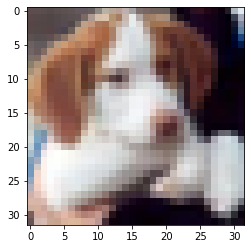

In [44]:
plt.imshow(x_test_adv[11])

In [45]:
y_test_adv[11]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

# Adversarial Patch

In [66]:
from art.attacks.evasion import AdversarialPatch
ge_cifar_new_clf = build_ganeval_model(False)

advPatch_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

advPatch_attack = AdversarialPatch(classifier=advPatch_clf, target=2)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [68]:
%%time
from art.attacks.evasion import AdversarialPatch
ge_cifar_new_clf = build_ganeval_model(False)

advPatch_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

advPatch_attack = AdversarialPatch(classifier=advPatch_clf, target=2)

patch, stencil = advPatch_attack.generate(x_test_adv.copy())
x_test_adv_attack = advPatch_attack.apply_patch(x_test_adv.copy(),scale=0.3)
loss ,acc = ge_cifar_new_clf.evaluate(x_test_adv_attack, y_test_adv)
preds = ge_cifar_new_clf.predict(x_test_adv_attack)

report = classification_report(np.argmax(y_test_adv, axis=1), 
                               np.argmax(preds, axis=1), 
                               output_dict=True)
report = report['weighted avg']
report.update({'Loss':loss})
report.update({'Accuracy':acc})
report.update({'Attack':'Adversarial Patch'})

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


20/20 [==============================] - 0s 9ms/sample - loss: 14.9678 - acc: 0.1000
CPU times: user 7min 11s, sys: 48 s, total: 7min 59s
Wall time: 1min 59s


/usr/local/anaconda3/envs/adver_tf1/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
x_test_adv_attack = advPatch_attack.apply_patch(x_test_adv.copy(),scale=0.3)
loss ,acc = ge_cifar_new_clf.evaluate(x_test_adv_attack, y_test_adv)
preds = ge_cifar_new_clf.predict(x_test_adv_attack)

20/20 [==============================] - 0s 3ms/sample - loss: 14.7447 - acc: 0.1000


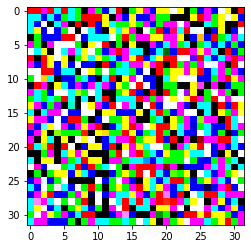

In [69]:
plt.imshow(patch1)

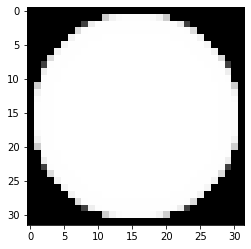

In [70]:
plt.imshow(patch2)

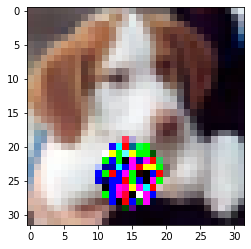

In [71]:
plt.imshow(x_test_adv_attack[11])

In [73]:
preds[11].round(4)

array([0.0215, 0.9784, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    ], dtype=float32)

In [ ]:
results.append(report)

# Decision-Based / Boundary Attack

In [103]:
from art.attacks.evasion import BoundaryAttack
ge_cifar_new_clf = build_ganeval_model()

boundary_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=True)

boundary_attack = BoundaryAttack(classifier=boundary_clf, targeted=False, 
                                 max_iter=10, 
                                 num_trial=5, sample_size=20, init_size=20)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [104]:
results.append(applyAttack("Decision-Based / Boundary Attack", boundary_attack, ge_cifar_new_clf))

KeyboardInterrupt: 

# Query-Efficient Black-Box Attack -> Different Implementation

In [106]:
from art.wrappers import QueryEfficientBBGradientEstimation
ge_cifar_new_clf = build_ganeval_model()
queryEffBlackBox_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=True)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [111]:
qeBlackBox_attack = QueryEfficientBBGradientEstimation(classifier=queryEffBlackBox_clf, 
                                                       num_basis=0, 
                                                       sigma=0, 
                                                       round_samples=0)
# classifier, num_basis, sigma, round_samples=0

In [112]:
qeBlackBox_attack._model.fit(x_test_adv, y_test_adv)

100/100 [==============================] - 0s 3ms/sample - loss: 0.3555 - acc: 0.9200


In [115]:
qeBlackBox_lossGradient = qeBlackBox_attack.loss_gradient(x_test_adv, y_test_adv)

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

In [116]:
qeBB_prediction = qeBlackBox_attack.predict(x_test_adv)

In [118]:
np.argmax(qeBB_prediction, axis=1)

array([0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 1, 1, 9, 1, 9, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 6, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [119]:
np.argmax(y_test_adv, axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

# Final Results of Attacks

In [88]:
results

[{'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 20.0,
  'Loss': 200.01431274414062,
  'Accuracy': 0.0,
  'Attack': 'Pixel Attack'},
 {'precision': 0.02222222222222222,
  'recall': 0.1,
  'f1-score': 0.03636363636363636,
  'support': 20,
  'Loss': 0.9367471933364868,
  'Accuracy': 0.1,
  'Attack': 'Hop Skip Jump Attack'},
 {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 20.0,
  'Loss': 50.75578308105469,
  'Accuracy': 0.0,
  'Attack': 'Projected Gradient Descent Attack'},
 {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 20.0,
  'Loss': 2.4494290351867676,
  'Accuracy': 0.0,
  'Attack': 'Newton Fool Attack'},
 {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 20.0,
  'Loss': 3.853330135345459,
  'Accuracy': 0.0,
  'Attack': 'Elastic Net Attack'},
 {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 20,
  'Loss': 0.012248705141246319,
  'Accuracy': 1.0,
  'Attack': 'Spatial Transformation Attack

In [89]:
import pandas as pd
df = pd.DataFrame(results)
df

,precision,recall,f1-score,support,Loss,Accuracy,Attack
0,0.000000,0.00,0.000000,20.0,200.014313,0.00,Pixel Attack
1,0.022222,0.10,0.036364,20.0,0.936747,0.10,Hop Skip Jump Attack
2,0.000000,0.00,0.000000,20.0,50.755783,0.00,Projected Gradient Descent Attack
3,0.000000,0.00,0.000000,20.0,2.449429,0.00,Newton Fool Attack
4,0.000000,0.00,0.000000,20.0,3.853330,0.00,Elastic Net Attack
5,1.000000,1.00,1.000000,20.0,0.012249,1.00,Spatial Transformation Attack
6,1.000000,1.00,1.000000,20.0,0.012249,1.00,Zeroth-Order Optimization Attack
7,0.020000,0.05,0.028571,20.0,3.294347,0.05,Carlini and Wagner L_inf Attack
8,0.000000,0.00,0.000000,20.0,1.163113,0.00,Jacobian Saliency Map Attack
9,0.011765,0.10,0.021053,20.0,6.646263,0.10,Universal perturbation Moosavi Attack


In [90]:
df.to_csv('AttacksResults20.csv')

# Query-Efficient Black-Box Attack

In [ ]:
from art.wrappers import QueryEfficientBBGradientEstimation
queryEffBlackBox_clf = KerasClassifier(model=ge_cifar_clf, clip_values=(0, 1), use_logits=False)

In [ ]:
qeBlackBox_attack = QueryEfficientBBGradientEstimation(classifier=queryEffBlackBox_clf, num_basis=0, sigma=0, round_samples=0)
# classifier, num_basis, sigma, round_samples=0

In [ ]:
qeBlackBox_attack.fit(testd[:10], testl[:10])

In [ ]:
qeBlackBox_lossGradient = qeBlackBox_attack.loss_gradient(testd[:10], testl[:10])

In [ ]:
qeBB_prediction = qeBlackBox_attack.predict(x_test[:10])

# Defences

In [206]:
x_test_adv, y_test_adv = sample_by_class(x_test, y_test, num_samples=10)

(100, 32, 32, 3) (100, 10)


In [267]:
# FGSM attack for applying Defence
from art.attacks.evasion import FastGradientMethod
ge_cifar_new_clfD = build_ganeval_model(True)

fgm_clfD = KerasClassifier(model=ge_cifar_new_clfD, clip_values=(0, 1), use_logits=True)

fgm_attack = FastGradientMethod(classifier=fgm_clfD, eps=0.01, eps_step=0.01, targeted=False, 
                                num_random_init=0, batch_size=1, minimal=False)

x_test_adv_fgm = fgm_attack.generate(x_test_adv.copy())

ge_cifar_new_clfD.evaluate(x_test_adv_fgm, y_test_adv)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


100/100 [==============================] - 0s 4ms/sample - loss: 3.9229 - acc: 0.4000


[3.9228776359558104, 0.4]

In [209]:
from art.metrics import empirical_robustness
er_fgsm = empirical_robustness(classifier=fgm_clfD, x=x_test_adv.copy(), attack_name='fgsm', attack_params=None)
er_fgsm

0.11388394647057314

# Gaussian Data Augmentation Defence

In [210]:
from art.defences.preprocessor import GaussianAugmentation
## do something

In [238]:
gaussian_defence = GaussianAugmentation(sigma=0.1, 
                                        augmentation=False, 
                                        ratio=0.1, 
                                        clip_values=(0,1), 
                                        apply_fit=False,
                                        apply_predict=True)
ge_cifar_clfD = build_ganeval_model(True)

art_clf = KerasClassifier(model=ge_cifar_clfD, clip_values=(0, 1), use_logits=True, 
                          preprocessing_defences=gaussian_defence)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [244]:
classification_report(np.argmax(art_clf.predict(x_test_adv_fgm),axis=1), 
                      np.argmax(y_test_adv,axis=1), output_dict=True)

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 '1': {'precision': 0.1,
  'recall': 0.14285714285714285,
  'f1-score': 0.11764705882352941,
  'support': 7},
 '2': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13},
 '3': {'precision': 0.3,
  'recall': 0.15789473684210525,
  'f1-score': 0.20689655172413793,
  'support': 19},
 '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '6': {'precision': 0.2,
  'recall': 0.18181818181818182,
  'f1-score': 0.1904761904761905,
  'support': 11},
 '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0},
 '9': {'precision': 0.5,
  'recall': 0.13157894736842105,
  'f1-score': 0.20833333333333334,
  'support': 38},
 'accuracy': 0.11,
 'macro avg': {'precision': 0.11000000000000001,
  'recall': 0.0614149008885851,
  'f1-score': 0.07233531

In [287]:
# FGSM attack after defence
fgm_attackAfterD = FastGradientMethod(classifier=art_clf, eps=0.3, eps_step=0.1, targeted=False, 
                                num_random_init=0, batch_size=1, minimal=False)
x_test_adv_fgmAfterD = fgm_attackAfterD.generate(x_test_adv.copy())
art_clf.evaluate(x_test_adv_fgm, y_test_adv)
er_fgsm = empirical_robustness(classifier=art_clf, x=x_test_adv.copy(), attack_name='fgsm', attack_params=None)
er_fgsm

AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

In [114]:
est_grad = gaussian_defence.estimate_gradient(x_test_adv[:50], grad = 0.001)
est_grad

0.001

In [ ]:
gaussian_defence

# Feature Squeezing

In [115]:
from art.defences.preprocessor import FeatureSqueezing

In [119]:
featureSqueezing_defence = FeatureSqueezing(clip_values=(0,255), bit_depth=8, apply_fit=True, apply_predict=False)
# clip_values = (min,max), bit_depth=8, apply_fit=False, apply_predict=True
featureSqueezing_defence

In [120]:
est_grad_featSqz = featureSqueezing_defence.estimate_gradient(x_test_adv[:50], grad = 0.001)
est_grad_featSqz

0.001

# High Confidence Defence

In [246]:
from art.defences.postprocessor import HighConfidence

In [292]:
highConf_defence = HighConfidence(cutoff=0.25, apply_fit=False, apply_predict=True)

ge_cifar_clfD = build_ganeval_model()

art_clf = KerasClassifier(model=ge_cifar_clfD, clip_values=(0, 1), use_logits=False, 
                          postprocessing_defences=highConf_defence)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [293]:
deepFool_attack = DeepFool(classifier=art_clf, max_iter=100, epsilon=1e-06, nb_grads=10, batch_size=1)
x_test_adv_fgmAfterD = deepFool_attack.generate(x_test_adv.copy())
ge_cifar_clfD.evaluate(x_test_adv_fgmAfterD, y_test_adv)
# er_fgsm = empirical_robustness(classifier=art_clf, x=x_test_adv.copy(), attack_name='fgsm', attack_params=None)
# er_fgsm

100/100 [==============================] - 0s 5ms/sample - loss: 0.8454 - acc: 0.3800


[0.8453696393966674, 0.38]

In [294]:
classification_report(np.argmax(art_clf.predict(x_test_adv_fgmAfterD),axis=1), 
                      np.argmax(y_test_adv,axis=1), output_dict=True)['weighted avg']

{'precision': 0.39899999999999997,
 'recall': 0.38,
 'f1-score': 0.37876462838099656,
 'support': 100}

In [273]:
# FGSM attack after defence
fgm_attackAfterD = FastGradientMethod(classifier=art_clf, eps=0.3, eps_step=0.1, targeted=False, 
                                num_random_init=0, batch_size=1, minimal=False)
x_test_adv_fgmAfterD = fgm_attackAfterD.generate(x_test_adv.copy())
ge_cifar_clfD.evaluate(x_test_adv_fgmAfterD, y_test_adv)
er_fgsm = empirical_robustness(classifier=art_clf, x=x_test_adv.copy(), attack_name='fgsm', attack_params=None)
er_fgsm

100/100 [==============================] - 0s 3ms/sample - loss: 5.8356 - acc: 0.1000


0.11388394647057314

In [266]:
classification_report(np.argmax(art_clf.predict(x_test_adv_fgmAfterD),axis=1), 
                      np.argmax(y_test_adv,axis=1), output_dict=True)['weighted avg']

{'precision': 0.406,
 'recall': 0.4,
 'f1-score': 0.3986819822689388,
 'support': 100}

# Rounding/Rounded Defence

In [288]:
from art.defences.postprocessor import Rounded

In [289]:
rounded_defence = Rounded(decimals=2, apply_fit=False, apply_predict=True)

ge_cifar_clfD = build_ganeval_model()

art_clf = KerasClassifier(model=ge_cifar_clfD, clip_values=(0, 1), use_logits=False, 
                          postprocessing_defences=rounded_defence)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [290]:
deepFool_attack = DeepFool(classifier=art_clf, max_iter=100, epsilon=1e-06, nb_grads=10, batch_size=1)
x_test_adv_fgmAfterD = deepFool_attack.generate(x_test_adv.copy())
ge_cifar_clfD.evaluate(x_test_adv_fgmAfterD, y_test_adv)

100/100 [==============================] - 0s 5ms/sample - loss: 0.8495 - acc: 0.3100


[0.8495443677902221, 0.31]

In [291]:
classification_report(np.argmax(art_clf.predict(x_test_adv_fgmAfterD),axis=1), 
                      np.argmax(y_test_adv,axis=1), output_dict=True)['weighted avg']

{'precision': 0.38800000000000007,
 'recall': 0.28,
 'f1-score': 0.3201063528386182,
 'support': 100}

In [278]:
# FGSM attack after defence
fgm_attackAfterD = FastGradientMethod(classifier=art_clf, eps=0.3, eps_step=0.1, targeted=False, 
                                num_random_init=0, batch_size=1, minimal=False)
x_test_adv_fgmAfterD = fgm_attackAfterD.generate(x_test_adv.copy())
ge_cifar_clfD.evaluate(x_test_adv_fgmAfterD, y_test_adv)
er_fgsm = empirical_robustness(classifier=art_clf, x=x_test_adv.copy(), attack_name='fgsm', attack_params=None)
er_fgsm

100/100 [==============================] - 0s 4ms/sample - loss: 5.8356 - acc: 0.1000


0.11388394647057314

# Virtual Adversarial Training Defence

In [103]:
from art.defences.trainer import AdversarialTrainer
advTrainer_clf = KerasClassifier(model=ge_cifar_new_clf, clip_values=(0, 1), use_logits=False)

In [104]:
adversarialTrainer_defence = AdversarialTrainer(classifier=advTrainer_clf, attacks=fgm_attack, ratio=0.5)

In [105]:
adversarialTrainer_defence.fit(x_train_adv[:50].copy(), y_train_adv[:50].copy())

1/1 [==============================] - 0s 139ms/step - loss: 3.1076 - acc: 0.4800


In [106]:
at_predictions = adversarialTrainer_defence.predict(x_test_adv[:50].copy())